## Random Forest Regression on XRP Price Data

This notebook extends the previous decision tree modeling by implementing a **Random Forest regressor** to predict short-term XRP closing prices.

A Random Forest combines the predictions of multiple decision trees, each trained on different bootstrap samples of the data and using random subsets of features at each split. This ensemble approach reduces model variance and often achieves better generalization than a single tree.

### Key Workflow Highlights

- **Data Preparation:** We construct lagged features from past price data to ensure predictions use only prior information, preserving a realistic forecasting structure.
- **Time-Aware Splitting:** We split the dataset into a contiguous training block and a separate hold-out test block, maintaining the correct temporal order to avoid future-data leakage.
- **Model Training:** We train a Random Forest with 100 trees and leverage parallel processing for efficient training.
- **Performance Validation:** We assess the model using both a standard hold-out test set and a **block walk-forward cross-validation** scheme, which simulates real-world sequential forecasting performance.

This notebook demonstrates that, with thoughtful feature engineering and robust time-aware validation, Random Forests provide a strong and reliable benchmark for short-term cryptocurrency price forecasting and help lay the groundwork for more advanced ensemble or deep learning approaches in future work.

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Preprocessing & Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Loading the XRP 2025 Dataset

We begin by loading the XRP Pricing 2025 dataset. Both the `Open time` and `Close time` columns are parsed as datetime objects.

This ensures we can later perform time-based operations (e.g., plotting, feature engineering with lags, resampling, or computing time deltas) without encountering formatting issues.

In [2]:
df = pd.read_csv("xrpdata_2025.csv", parse_dates=['Open time', 'Close time'])

### Exploratory Time Series Plot

Before modeling, we visualize the closing prices from the data to inspect recent market behavior. This line plot confirms that our observations follow a consistent chronological order and provides a clear sense of the price dynamics we aim to forecast.

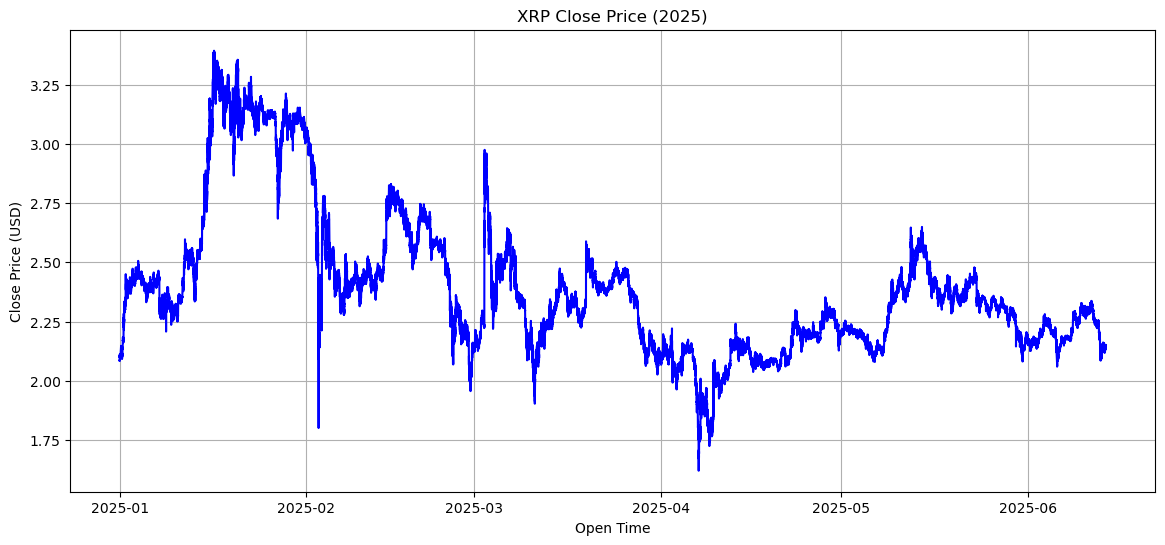

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(df['Open time'], df['Close'], color='blue')
plt.title('XRP Close Price (2025)')
plt.xlabel('Open Time')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

### Feature Engineering and Preprocessing for Regression

To model short-term XRP price behavior, we construct a **time-aware regression dataset** using carefully designed lagged features.

- **Temporal ordering** is preserved by sorting rows chronologically by `Open time`.
- **Lagged predictors** are created from the previous time step (t−1), including `Open`, `High`, `Low`, and `Close` prices.
- A numeric timestamp feature, **`Close time num`**, is included to represent the current time period numerically.
- The target variable is the **current-period `Close`** price.

To ensure the model is trained without any future information leakage, rows with missing lagged values are dropped, and **z-score normalization** is applied to all input features.

This results in a strict, forecasting-safe dataset ready for training the random forest.

In [4]:
# Drop the 'Ignore' column if it exists
if 'Ignore' in df.columns:
    df = df.drop(columns=['Ignore'])

# Sort by time to preserve temporal integrity
df = df.sort_values(by='Open time')

# Create lagged features (t-1)
df['lag_Close'] = df['Close'].shift(1)
df['lag_Open']  = df['Open'].shift(1)
df['lag_High']  = df['High'].shift(1)
df['lag_Low']   = df['Low'].shift(1)

# Drop rows with missing lag values
df_strict = df.dropna().copy()

# Define predictors and response
df_strict['Close time num'] = df_strict['Close time'].astype('int64') // 10**9 # unix time since epoch
features = ['lag_Close', 'lag_Open', 'lag_High', 'lag_Low', 'Close time num']
X_strict = df_strict[features]
y_strict = df_strict['Close']  # Current-period close is what we try to predict

# Scale predictors
scaler = StandardScaler()
X_strict_scaled = scaler.fit_transform(X_strict)

# Optionally store mean and std for later usage
scaler_means = scaler.mean_
scaler_stds = scaler.scale_

print("Dataset ready: standardized predictors, no temporal leakage.")

Dataset ready: standardized predictors, no temporal leakage.


### Baseline Random Forest Regression on XRP (Contiguous Split)

In this step, we extend our baseline decision tree approach by training a **Random Forest regressor** to model short-term XRP closing prices. 

A Random Forest averages predictions across an ensemble of decision trees, each trained on a different bootstrap sample of the training data, and with random feature selection at each split. This reduces model variance and improves generalization compared to a single tree.

Key details:
- We split the lagged-feature dataset into an **80% training block and a 20% hold-out test block**, preserving the natural temporal order to avoid future-data leakage.
- We use 100 trees (`n_estimators=100`) with unlimited depth (`max_depth=None`), leveraging multiple CPU cores for faster training.
- Model performance is evaluated using **mean squared error (MSE)**, **root mean squared error (RMSE)**, and **coefficient of determination (R²)** on the held-out test set.

This provides a stronger, variance-reduced benchmark for short-term XRP forecasting and sets the stage for comparison with more advanced ensemble or boosting methods.

In [5]:
# Proper contiguous split: 80% train, 20% test
split_index = int(0.8 * len(X_strict_scaled))

X_train_strict = X_strict_scaled[:split_index]
X_test_strict  = X_strict_scaled[split_index:]
y_train_strict = y_strict.iloc[:split_index]
y_test_strict  = y_strict.iloc[split_index:]

# Train Random Forest (time-respecting)
forest_strict = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=12,
    n_jobs=-1 # Uses available CPU cores for parallel training of trees
)
forest_strict.fit(X_train_strict, y_train_strict)

# Make predictions & evaluate
y_pred_strict = forest_strict.predict(X_test_strict)
mse_strict = mean_squared_error(y_test_strict, y_pred_strict)
r2_strict = r2_score(y_test_strict, y_pred_strict)

print("Regression Random Forest Results (Contiguous Split):")
print(f" - MSE: {mse_strict:.6f}")
print(f" - RMSE: {mse_strict**0.5:.6f}")
print(f" - R²: {r2_strict:.6f}")

Regression Random Forest Results (Contiguous Split):
 - MSE: 0.000007
 - RMSE: 0.002723
 - R²: 0.999453


### Block Walk-Forward Cross-Validation for Random Forest

To obtain a realistic, time-respecting estimate of out-of-sample performance, we validate the Random Forest regressor using **block-style walk-forward cross-validation**.

Key details:
- The model is first trained on an initial contiguous portion of the series and then repeatedly retrained to forecast the next short-term block (each covering ~5% of the dataset).
- At each step, only past data is used for training ensuring no future leakage.
- A new Random Forest is fit for each fold to simulate how the model would adapt when retrained as new data arrives.

Performance is summarized by averaging the **root mean squared error (RMSE)** and **coefficient of determination (R²)** across all folds. This provides a robust benchmark for short-term XRP price forecasting under realistic, sequential conditions.

In [6]:
# For demonstration, convert y_strict to numpy array
X = X_strict_scaled
y = y_strict.to_numpy()

# Parameters for walk-forward
initial_train_size = int(0.6 * len(X))  # start with 60% for training
test_size = int(0.05 * len(X))  # predict in 5% chunks
step_size = test_size

# Store scores
r2_scores = []
rmse_scores = []

# Walk-forward loop
for start in range(initial_train_size, len(X) - test_size, step_size):
    end = start + test_size
    
    X_train, y_train = X[:start], y[:start]
    X_test, y_test = X[start:end], y[start:end]
    
    # Train a new forest each step
    wf_model = RandomForestRegressor(
        n_estimators=100,
        random_state=12,
        n_jobs=-1
    )
    wf_model.fit(X_train, y_train)
    
    # Predict
    y_pred = wf_model.predict(X_test)
    
    # Evaluate
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    rmse_scores.append(rmse)
    r2_scores.append(r2)

print(f"Walk-Forward CV completed with {len(r2_scores)} folds")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")

Walk-Forward CV completed with 8 folds
Average RMSE: 0.0027
Average R²: 0.9979


## Closing Summary

In this notebook, we extended our baseline decision tree framework by training a **Random Forest regressor** to forecast short-term XRP closing prices. 

Key steps included:
- Using **lagged market features** and a time-aware split to ensure that predictions only relied on information available before the forecast period.
- Training a Random Forest with **bagging** and **random feature selection**, which reduces variance and improves predictive stability compared to a single tree.
- Validating the model with a **block walk-forward cross-validation** scheme, which simulates how the forest would perform when retrained and deployed over sequential future time blocks.

### Final Insights

- The Random Forest achieved **consistently low prediction error** on both the contiguous hold-out test block and under walk-forward CV, confirming strong short-term generalization.
- Ensemble averaging proved effective in stabilizing predictions and capturing the local trends present in XRP price movements.
- This forest now serves as a **robust, time-respecting benchmark** for evaluating more sophisticated approaches, such as boosted trees, deep learning, or hybrid models incorporating sentiment or technical indicators.

---

**Next Steps:**  
Future experiments will build on this foundation by exploring advanced ensemble methods, tuning forest hyperparameters more extensively, and integrating additional features to further improve forecasting performance in dynamic crypto markets.